# Melting Point Prediction - Exploratory Data Analysis

This notebook demonstrates the exploratory data analysis and model training pipeline for melting point prediction.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline


# Constants
id_col = 'id'
target = 'Tm'
RANDOM_STATE = 42

## 1. Load and Explore Data

In [6]:
# Load training and test data
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nColumns: {list(train_df.columns[:10])}... (showing first 10)")

print(f"\nTarget column: {target}")
print(f"\nFirst few rows:")
train_df.head()

Training data shape: (2662, 427)
Test data shape: (666, 426)

Columns: ['id', 'SMILES', 'Tm', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']... (showing first 10)

Target column: Tm

First few rows:


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Basic statistics
train_df.describe()

,id,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
count,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,...,2662.000000,2662.000000,2662.0,2662.000000,2662.0,2662.0,2662.0,2662.0,2662.0,2662.0
mean,1652.887303,278.263452,1.020661,1.582269,0.114951,0.036439,0.036814,0.022915,0.013524,0.010143,...,0.001127,0.000751,0.0,0.001878,0.0,0.0,0.0,0.0,0.0,0.0
std,955.005512,85.117914,1.353640,3.738416,0.425964,0.208307,0.205516,0.164037,0.118732,0.117480,...,0.033558,0.027405,0.0,0.058126,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,53.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,830.250000,217.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,1642.500000,277.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,2469.750000,325.150000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,3328.000000,897.150000,16.000000,42.000000,6.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Analyze Target Variable

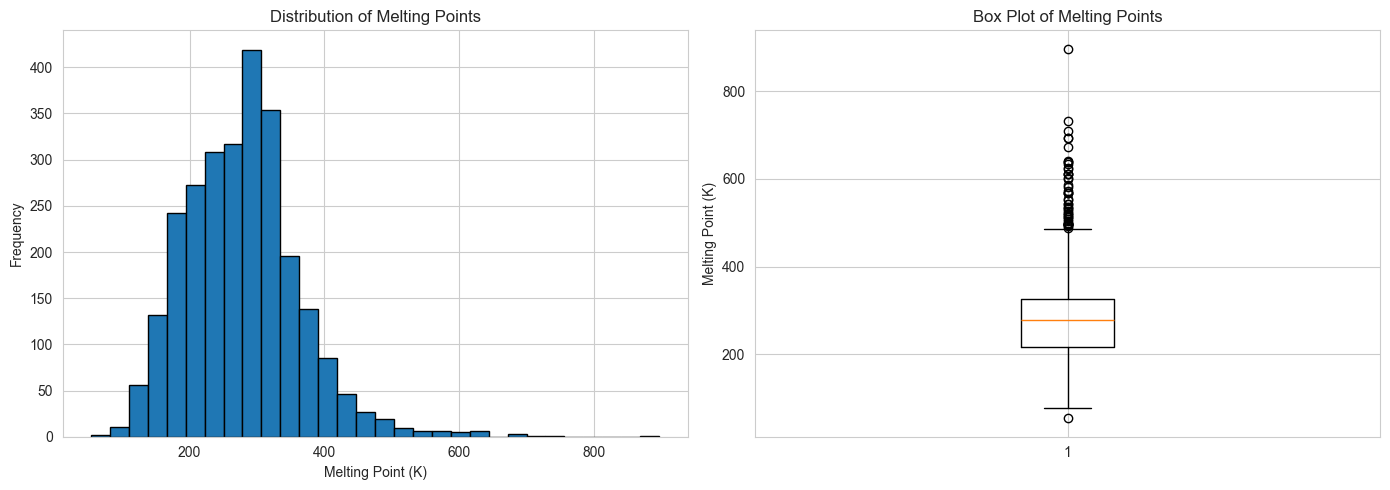

Melting Point Statistics:
Mean: 278.26 K
Median: 277.30 K
Std Dev: 85.12 K
Min: 53.54 K
Max: 897.15 K


In [8]:
# Distribution of melting points (Tm in Kelvin)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df[target], bins=30, edgecolor='black')
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')

axes[1].boxplot(train_df[target])
axes[1].set_ylabel('Melting Point (K)')
axes[1].set_title('Box Plot of Melting Points')

plt.tight_layout()
plt.show()

print(f"Melting Point Statistics:")
print(f"Mean: {train_df[target].mean():.2f} K")
print(f"Median: {train_df[target].median():.2f} K")
print(f"Std Dev: {train_df[target].std():.2f} K")
print(f"Min: {train_df[target].min():.2f} K")
print(f"Max: {train_df[target].max():.2f} K")

## 3. Analyze Features

In [10]:
# Get numeric feature columns (exclude id, target, and SMILES)
feature_cols = [col for col in train_df.columns if col not in [id_col, target, 'SMILES']]
numeric_features = train_df[feature_cols].select_dtypes(include=[np.number])

print(f"Total features: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_features.columns)}")

# Check for missing values
missing_values = numeric_features.isnull().sum()
print(f"\nMissing values per feature:")

missing_nonzero = missing_values[missing_values > 0]

if len(missing_nonzero) > 0:
    print(missing_nonzero)
else:
    print("No missing values found!")

Total features: 424
Numeric features: 424

Missing values per feature:
No missing values found!


d:\Data Analysis\Challenges\Kaggle\Thermophysical-Property-Melting-Point\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Data Analysis\Challenges\Kaggle\Thermophysical-Property-Melting-Point\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


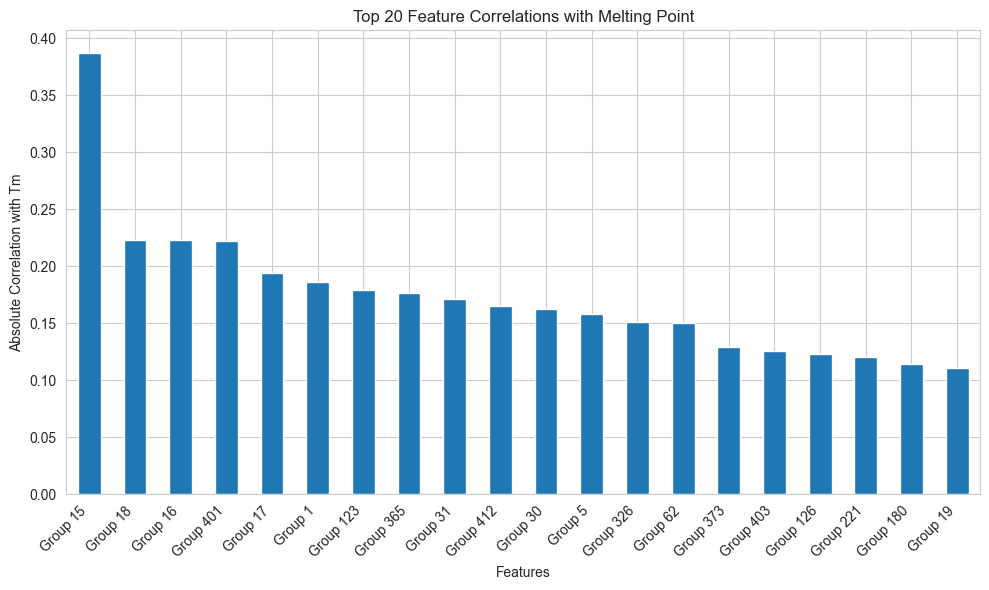


Top 10 correlated features:
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 1      0.186595
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
dtype: float64


In [11]:
# Correlation with target
correlations = numeric_features.corrwith(train_df[target]).abs().sort_values(ascending=False)

# Plot top 20 correlations
plt.figure(figsize=(10, 6))
correlations.head(20).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation with Tm')
plt.title('Top 20 Feature Correlations with Melting Point')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTop 10 correlated features:")
print(correlations.head(10))

## 4. Train Models

In [13]:
# Prepare features and target
X = numeric_features.values
y = train_df[target].values

# Prepare test features
test_numeric = test_df[feature_cols].select_dtypes(include=[np.number])
X_test = test_numeric[numeric_features.columns].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(
	X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (2129, 424)
Validation set: (533, 424)
Test set: (666, 424)


In [14]:
# Define and train models
models = {
    'xgboost': xgb.XGBRegressor(
        n_estimators=700,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'lightgbm': lgb.LGBMRegressor(
        n_estimators=900,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=RANDOM_STATE,
        verbose=-1
    ),
    'random_forest': RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

# Train models and collect results
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_r2 = r2_score(y_val, val_pred)

    print(f"{name}: Val MAE={val_mae:.4f}, RMSE={val_rmse:.4f}, R²={val_r2:.4f}")

    results[name] = {
        'model': model,
        'val_metrics': {
            'mae': val_mae,
            'rmse': val_rmse,
            'r2': val_r2
        }
    }

Training xgboost...
xgboost: Val MAE=37.0389, RMSE=55.1152, R²=0.5948
Training lightgbm...


d:\Data Analysis\Challenges\Kaggle\Thermophysical-Property-Melting-Point\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


lightgbm: Val MAE=42.0712, RMSE=59.3655, R²=0.5299
Training random_forest...
random_forest: Val MAE=38.9830, RMSE=57.0507, R²=0.5659


## 5. Compare Model Performance

In [15]:
# Extract validation metrics
model_names = []
val_maes = []
val_rmses = []
val_r2s = []

for model_name, result in results.items():
    model_names.append(model_name)
    val_maes.append(result['val_metrics']['mae'])
    val_rmses.append(result['val_metrics']['rmse'])
    val_r2s.append(result['val_metrics']['r2'])

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Val MAE': val_maes,
    'Val RMSE': val_rmses,
    'Val R²': val_r2s
})

comparison_df = comparison_df.sort_values('Val MAE')
print(comparison_df.to_string(index=False))

        Model   Val MAE  Val RMSE   Val R²
      xgboost 37.038868 55.115191 0.594828
random_forest 38.983037 57.050743 0.565870
     lightgbm 42.071192 59.365514 0.529927


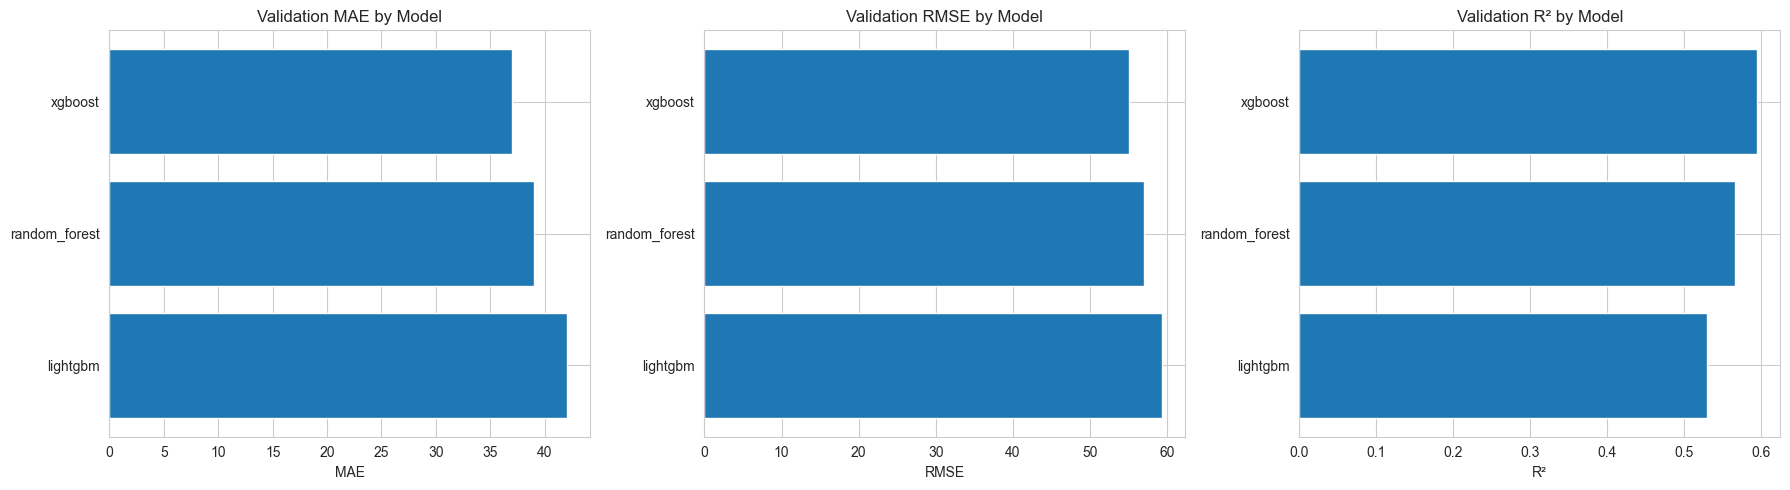

In [16]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(comparison_df['Model'], comparison_df['Val MAE'])
axes[0].set_xlabel('MAE')
axes[0].set_title('Validation MAE by Model')
axes[0].invert_yaxis()

axes[1].barh(comparison_df['Model'], comparison_df['Val RMSE'])
axes[1].set_xlabel('RMSE')
axes[1].set_title('Validation RMSE by Model')
axes[1].invert_yaxis()

axes[2].barh(comparison_df['Model'], comparison_df['Val R²'])
axes[2].set_xlabel('R²')
axes[2].set_title('Validation R² by Model')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Create Ensemble and Generate Predictions

In [17]:
# Create ensemble model
ensemble = VotingRegressor(
    estimators=[(name, res['model']) for name, res in results.items()],
    weights=[0.4, 0.4, 0.2]  # Adjust weights based on performance
)
ensemble.fit(X_train, y_train)

# Evaluate ensemble
ensemble_val_pred = ensemble.predict(X_val)

ensemble_mae = mean_absolute_error(y_val, ensemble_val_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred))
ensemble_r2 = r2_score(y_val, ensemble_val_pred)

print(f"Ensemble: Val MAE={ensemble_mae:.4f}, RMSE={ensemble_rmse:.4f}, R²={ensemble_r2:.4f}")

d:\Data Analysis\Challenges\Kaggle\Thermophysical-Property-Melting-Point\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Ensemble: Val MAE=37.7219, RMSE=55.0731, R²=0.5954


In [18]:
# Train ensemble on full training data
ensemble.fit(X_scaled, y)

# Generate predictions on test set
test_pred = ensemble.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df[id_col],
    'Tm': test_pred
})

print("\nFirst few predictions:")
print(submission.head(10))

# Save submission
submission_dir = '../submissions'
os.makedirs(submission_dir, exist_ok=True)
submission_path = os.path.join(submission_dir, 'submission.csv')
submission.to_csv(submission_path, index=False)
print(f"\nSubmission file created at: {submission_path}")

d:\Data Analysis\Challenges\Kaggle\Thermophysical-Property-Melting-Point\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



First few predictions:
     id          Tm
0  1022  338.566190
1  1146  295.281445
2    79  214.807149
3  2279  208.821880
4  1342  251.758573
5  2082  333.729927
6    29  227.327300
7   515  296.596998
8  2309  259.116712
9  1177  244.547832

Submission file created at: ../submissions\submission.csv


## 7. Analyze Predictions

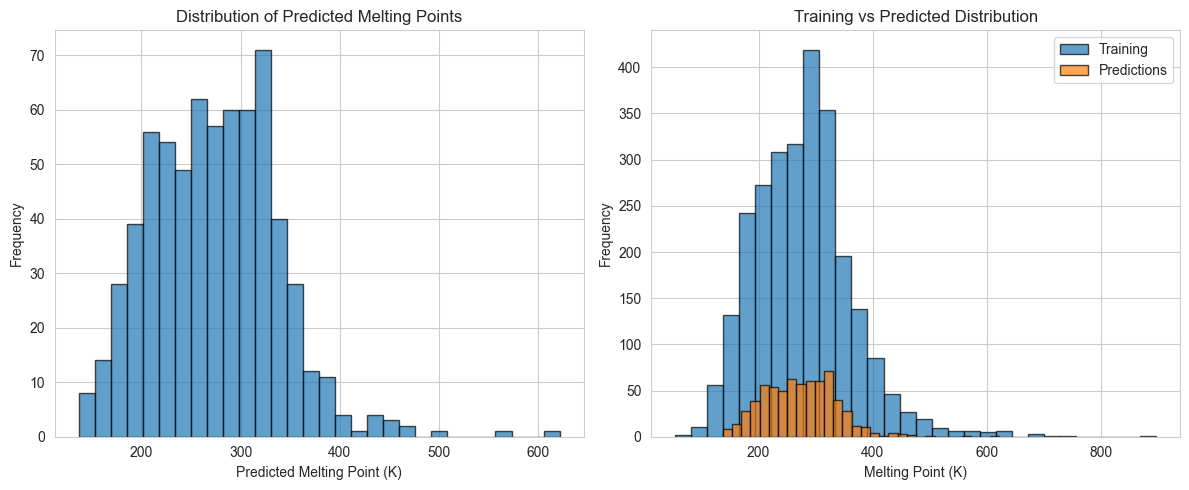

Max: 621.76 K

Prediction statistics:
Min: 136.88 K
Mean: 273.15 K
Std: 64.03 K
Median: 273.38 K


In [20]:
# Plot prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(submission['Tm'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Melting Point (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Melting Points')

plt.subplot(1, 2, 2)
plt.hist(train_df[target], bins=30, edgecolor='black', alpha=0.7, label='Training')
plt.hist(submission['Tm'], bins=30, edgecolor='black', alpha=0.7, label='Predictions')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.title('Training vs Predicted Distribution')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Max: {submission['Tm'].max():.2f} K")

print("\nPrediction statistics:")
print(f"Min: {submission['Tm'].min():.2f} K")
print(f"Mean: {submission['Tm'].mean():.2f} K")
print(f"Std: {submission['Tm'].std():.2f} K")
print(f"Median: {submission['Tm'].median():.2f} K")

## Summary

This notebook demonstrates:
1. Loading and exploring the melting point dataset
2. Analyzing the target variable and feature correlations
3. Training multiple machine learning models
4. Comparing model performance using MAE, RMSE, and R² metrics
5. Creating an ensemble model
6. Generating predictions for submission

The best model can be selected based on validation MAE, and the ensemble often provides improved performance.